# Regressão Linear 

![](https://miro.medium.com/max/482/1*D6s2K1y7kjE14swcgITB1w.png)

### **Você sabe quanto vale o imóvel em que você mora? Como você faria para predizer esse valor?**

![](https://media.giphy.com/media/eoje0OqGEx5Oo/giphy.gif)

O que _**prever o valor de um imóvel**_ tem em comum com prever...
- a renda de uma pessoa
- a quantidade de vendas de uma loja
- o número de leads de uma empresa

?

Para todos esses problemas, o objetivo é **predizer um valor contínuo**. Esses são problemas de **REGRESSÃO**!

Regressão é um tipo de tarefa de aprendizado supervisionado, no qual treinamos um modelo de Machine Learning com um conjunto de dados rotulado:

<img src="https://i.vas3k.ru/7vx.jpg" width="500"/>

(Diagrama retirado [daqui](https://vas3k.com/blog/machine_learning/))

Existem diversos algoritmos para resolver esses problemas de regressão. Um deles é a Regressão Linear:

<tr>
    <td> <img src="https://image.slidesharecdn.com/8-1209490505240696-9/95/multiple-linear-regression-16-638.jpg?cb=1489720634" width="450"/></td>
    <td> <img src="https://cdn-images-1.medium.com/max/1600/1*eeIvlwkMNG1wSmj3FR6M2g.gif" width="450" /> </td>
</tr>    

Mas como a regressão linear encontra essa curva que melhor explica a relação entre uma feature e o target?

Ela usa um método chamado de Ordinary Least Squares (OLS), no qual a melhor curva será aquela que produzir a menor soma de erros quadrados. Mais detalhes sobre esse método podem ser encontrado [aqui](https://towardsdatascience.com/understanding-the-ols-method-for-simple-linear-regression-e0a4e8f692cc) (esse artigo menciona algumas suposições feitas pela regressão linear, como a [homocedasticidade](https://www3.nd.edu/~rwilliam/stats2/l25.pdf)).

## Exemplo - predição do valor de uma corrida de táxi

<img src="https://media.giphy.com/media/eKt8k3KQLRSFbP4v3f/giphy.gif" width="300"/>

Vamos usar a regressão linear para predizer o valor a ser pago em uma corrida de táxi.

## Bibliotecas auxiliares

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

In [ ]:
import warnings
warnings.simplefilter(action='ignore')

O nosso conjunto de dados contém as corridas de táxi da cidade de New York:

In [ ]:
df = pd.read_csv("dataset.csv")

In [ ]:
df.shape

(1000000, 8)

#### Descrição do conjunto de dados

|Campo            | Descrição                                                  |
|-----------------|------------------------------------------------------------|
|key              |chave única indicando cada exemplo                          |
|**fare_amount**  |valor, em doláres, indicando o valor pago na corrida de táxi|
|pickup_datetime  |timestamp indicando quando a corrida começou                |
|pickup_longitude |longitude na qual a corrida de táxi começou                 |
|pickup_latitude  |latitude na qual a corrida de táxi começou                  |
|dropoff_longitude|longitude na qual a corrida de táxi acabou                  |
|dropoff_latitude |latitude na qual a corrida de táxi acabou                   |
|passenger_count  |número de passageiros                                       |

In [ ]:
df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


Apenas observando essas features, quais vocês acham que podem nos ajudar a predizer o valor da corrida? Podemos criar alguma feature nova a partir delas?

## Análise exploratória e Feature engineering

### Valores faltantes

Como tínhamos visto anteriomente, são poucos os casos de valores faltantes em nosso conjunto de dados. 
Nesse caso, vamos simplesmente excluir esses exemplos:

In [ ]:
print(f'Tamanho conjunto de dados (antes da remoção de valores faltantes): {len(df)}')
df.dropna(inplace=True)
print(f'Tamanho conjunto de dados (depois da remoção de valores faltantes): {len(df)}')

Tamanho conjunto de dados (antes da remoção de valores faltantes): 1000000
Tamanho conjunto de dados (depois da remoção de valores faltantes): 999990


### Distribuição das features

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,999990,999990,2009-06-15 17:26:21.0000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare_amount,999990.0,NaN,NaN,NaN,11.347953,9.82179,-44.9,6.0,8.5,12.5,500.0
pickup_datetime,999990,861747,2010-02-13 19:28:00 UTC,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_longitude,999990.0,NaN,NaN,NaN,-72.526699,12.057778,-3377.680935,-73.99206,-73.981792,-73.967094,2522.271325
pickup_latitude,999990.0,NaN,NaN,NaN,39.92904,7.626087,-3116.285383,40.734965,40.752695,40.767154,2621.62843
dropoff_longitude,999990.0,NaN,NaN,NaN,-72.52786,11.324494,-3383.296608,-73.991385,-73.980135,-73.963654,45.581619
dropoff_latitude,999990.0,NaN,NaN,NaN,39.919954,8.201418,-3114.338567,40.734046,40.753166,40.768129,1651.553433
passenger_count,999990.0,NaN,NaN,NaN,1.684941,1.323907,0.0,1.0,1.0,2.0,208.0


Conforme podemos notar acima, há algumas coisas estranhas...Por exemplo, o número máximo de passageiros em uma corrida é de 208!

![](https://media.giphy.com/media/yy6hXyy2DsM5W/giphy.gif)

Vamos analisar esses casos separadamente para cada uma dessas features:

### Análise das features (e do target)

**`fare_amount`**

Começando pelo target, podemos ver a sua distribuição:

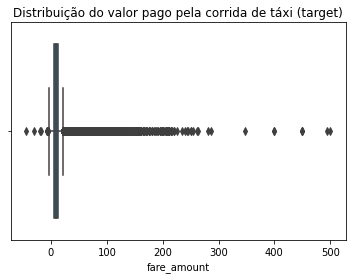

In [ ]:
sns.boxplot(df.fare_amount).set_title("Distribuição do valor pago pela corrida de táxi (target)");

Com esse boxplot e com a distribuição, podemos notar que temos casos de corridas em que o valor pago foi menor do que 1 dólar (até mesmo negativo!). Temos 75 exemplos nessa situação:

In [ ]:
len(df.loc[(df.fare_amount < 1)])

75

Também podemos notar valores de corridas muito elevados (chegando até 500 dólares!). Esses casos são outliers também, visto que somente em 396 exemplos (de 1 milhão) o valor pago foi acima de 100 doláres:

In [ ]:
len(df.loc[(df.fare_amount > 100)])

396

Vamos remover esses dois casos de exemplos do nosso conjunto de dados:

In [ ]:
df = df.loc[(df.fare_amount >= 1) & (df.fare_amount <= 100)]

Podemos ver as distribuições novamente:

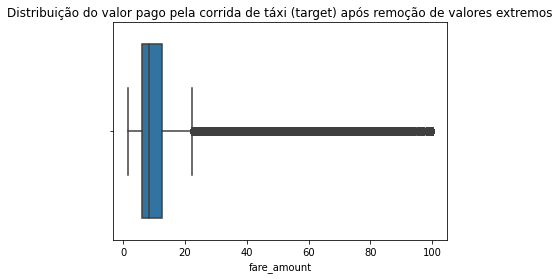

In [ ]:
sns.boxplot(df.fare_amount).set_title("Distribuição do valor pago pela corrida de táxi (target) após remoção de valores extremos");

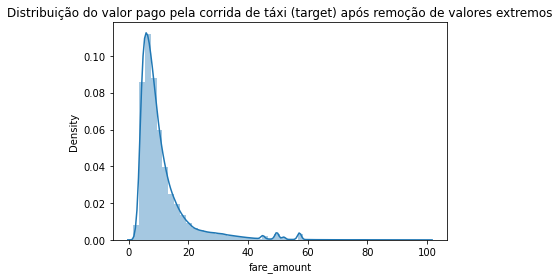

In [ ]:
sns.distplot(df.fare_amount).set_title("Distribuição do valor pago pela corrida de táxi (target) após remoção de valores extremos");

A visualização melhorou consideravelmente! Ainda podemos ver que as corridas acima de 20 doláres são mais raras, visto que para 75% do nosso conjunto de dados a corrida foi de até 12.5 doláres. Também podemos notar alguns picos entre 40 e 60 doláres.

**`pickup_datetime`**

Essa feature que indica quando a corrida começou precisa ser convertida para uma data para que possamos trabalhar com ela:

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999519 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                999519 non-null  object        
 1   fare_amount        999519 non-null  float64       
 2   pickup_datetime    999519 non-null  datetime64[ns]
 3   pickup_longitude   999519 non-null  float64       
 4   pickup_latitude    999519 non-null  float64       
 5   dropoff_longitude  999519 non-null  float64       
 6   dropoff_latitude   999519 non-null  float64       
 7   passenger_count    999519 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 68.6+ MB


Mesmo com essa conversão, ainda não conseguimos usar essa informação do jeito que está. Podemos quebrá-la em várias features diferentes:

In [ ]:
# horário
df['pickup_hour']=df['pickup_datetime'].apply(lambda x:x.hour)
# dia da semana (0 é segunda e 6 é domingo)
df['pickup_day_of_week']=df['pickup_datetime'].apply(lambda x:x.weekday())
# dia
df['pickup_day']=df['pickup_datetime'].apply(lambda x:x.day)
# mês
df['pickup_month']=df['pickup_datetime'].apply(lambda x:x.month)
# ano
df['pickup_year']=df['pickup_datetime'].apply(lambda x:x.year)

In [ ]:
df.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day_of_week,pickup_day,pickup_month,pickup_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,0,15,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,1,5,1,2010


**Horário**

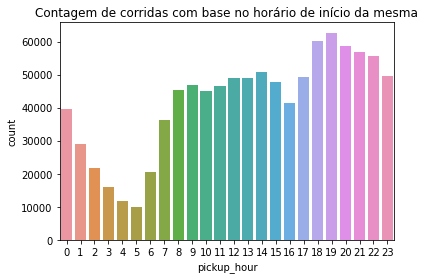

In [ ]:
sns.countplot(df['pickup_hour']).set_title("Contagem de corridas com base no horário de início da mesma");

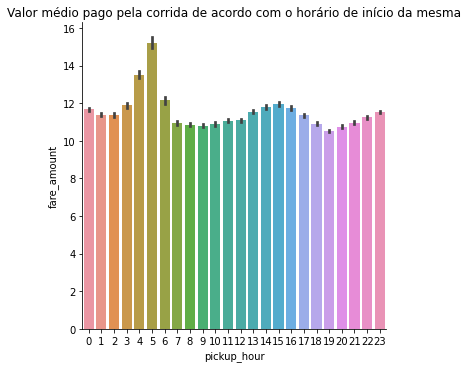

In [ ]:
sns.catplot(x="pickup_hour", y="fare_amount", data=df,kind="bar").set(title="Valor médio pago pela corrida de acordo com o horário de início da mesma");

Nos gráficos acima, podemos notar que as corridas que começam na madrugada são menos frequentes. Por outro lado, a média dos seus valores parece maior do que dos demais horários.

**Dia da semana**

In [ ]:
# Vamos fazer a conversão dos dias da semana para facilitar a leitura
def convert_day_of_week(day_of_week):
    day_dict={0:'Segunda',1:'Terça',2:'Quarta',3:'Quinta',4:'Sexta',5:'Sábado',6:'Domingo'}
    return day_dict[day_of_week]

In [ ]:
df['pickup_day_of_week_name']=df['pickup_day_of_week'].apply(lambda x:convert_day_of_week(x))

In [ ]:
week_day_name = ['Segunda','Terça','Quarta','Quinta','Sexta','Sábado','Domingo']

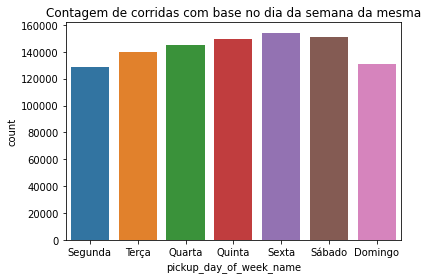

In [ ]:
sns.countplot(df['pickup_day_of_week_name'],order=week_day_name).set_title("Contagem de corridas com base no dia da semana da mesma");

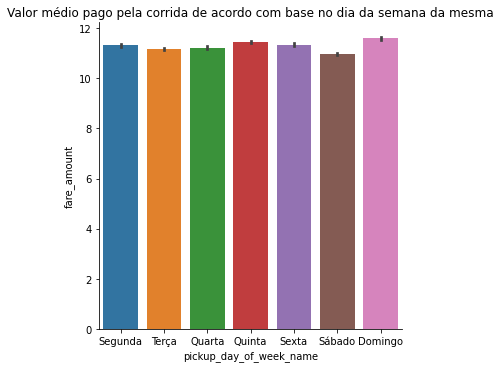

In [ ]:
sns.catplot(x="pickup_day_of_week_name", y="fare_amount", data=df,
            order=week_day_name,kind="bar").set(title="Valor médio pago pela corrida de acordo com base no dia da semana da mesma");

De acordo com os gráficos, podemos notar que o pico no número de corridas ocorre nas sextas-feiras. Por outro lado, a média do valor pago pelas corridas parece um pouco maior no domingo do que nos demais dias da semana.

**Dia**

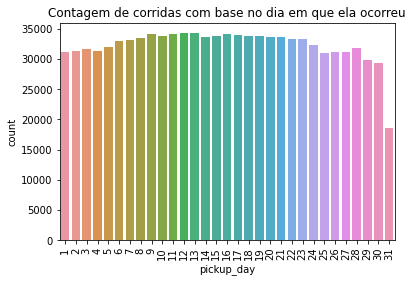

In [ ]:
sns.countplot(df['pickup_day']).set_title("Contagem de corridas com base no dia em que ela ocorreu");
plt.xticks(rotation=90);

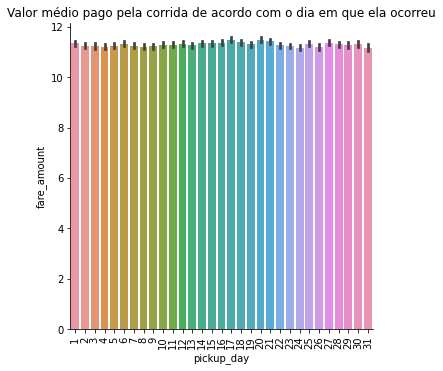

In [ ]:
sns.catplot(x="pickup_day", y="fare_amount", data=df,kind="bar").set(title="Valor médio pago pela corrida de acordo com o dia em que ela ocorreu");
plt.xticks(rotation=90);

Aparentemente temos menos corridas nos dias 31 (o que faz sentido dado que nem todos os meses vão até esse dia). Já observando a média dos valores pagos por dia da semana, não conseguimos notar uma clara diferença.

**Mês**

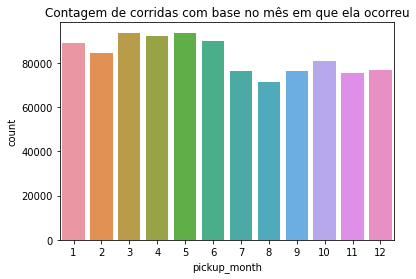

In [ ]:
sns.countplot(df['pickup_month']).set_title("Contagem de corridas com base no mês em que ela ocorreu");

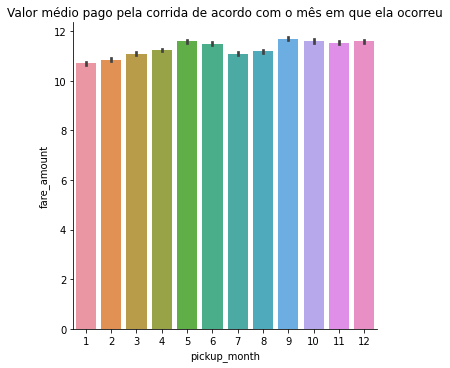

In [ ]:
sns.catplot(x="pickup_month", y="fare_amount", data=df,kind="bar").set(title="Valor médio pago pela corrida de acordo com o mês em que ela ocorreu");

Com relação ao mês, aparentemente mais corridas de táxi são feitas no primeiro semestre do que no segundo. Já em relação à média do valor pago, os meses do começo do ano e do meio do ano parecem ter valores menores do que os demais meses. 

**Ano**

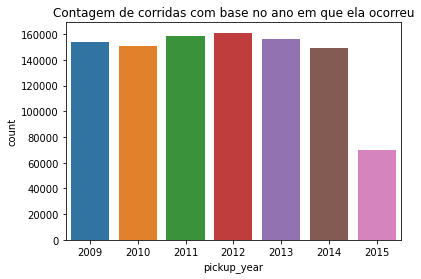

In [ ]:
sns.countplot(df['pickup_year']).set_title("Contagem de corridas com base no ano em que ela ocorreu");

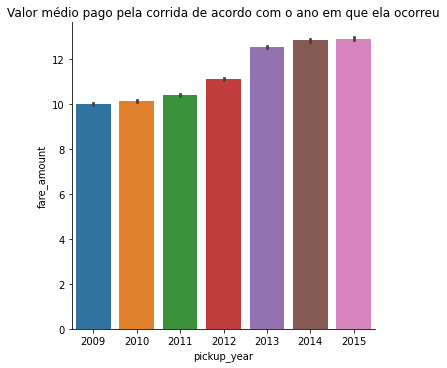

In [ ]:
sns.catplot(x="pickup_year", y="fare_amount", data=df,kind="bar").set(title="Valor médio pago pela corrida de acordo com o ano em que ela ocorreu");

Para a feature que indica o ano da corrida, podemos notar que o ano de 2015 contém bem menos corridas no nosso conjunto de dados do que os demais anos. Uma hipótese para que isso tenha acontecido é que o conjunto de dados foi coletado no meio desse ano e, portanto, ainda não haviam dados do ano inteiro.

Com relação ao valor pago, podemos notar que há uma tendência de crescimento na média do valor pago pela corrida conforme os anos vão passando.

**`latitude e longitude`**

In [ ]:
df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,999519.000000,999519.000000,999519.000000,999519.000000
mean,39.930365,-72.529162,39.921741,-72.531198
std,7.623472,12.051418,8.198080,11.314573
min,-3116.285383,-3377.680935,-3114.338567,-3383.296608
25%,40.734977,-73.992061,40.734055,-73.991382
50%,40.752697,-73.981796,40.753166,-73.980136
75%,40.767151,-73.967110,40.768122,-73.963666
max,2621.628430,2522.271325,1651.553433,45.581619


As coordenadas de latitude variam apenas entre -90 e 90, enquanto que a longitude varia apenas entre -180 e 180. 
Podemos excluir todos os exemplos cujas longitudes e latitudes estão fora desse intervalo:

In [ ]:
print(f'Tamanho conjunto de dados (antes da remoção de valores faltantes): {len(df)}')
df = df.loc[(df.pickup_latitude>=-90) & (df.pickup_latitude<=90)]
df = df.loc[(df.pickup_longitude>=-180) & (df.pickup_longitude<=180)]
df = df.loc[(df.dropoff_latitude>=-90) & (df.dropoff_latitude<=90)]
df = df.loc[(df.dropoff_longitude>=-180) & (df.dropoff_longitude<=180)]
print(f'Tamanho conjunto de dados (depois da remoção de valores faltantes): {len(df)}')

Tamanho conjunto de dados (antes da remoção de valores faltantes): 999519
Tamanho conjunto de dados (depois da remoção de valores faltantes): 999479


In [ ]:
df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,999479.000000,999479.000000,999479.000000,999479.000000
mean,39.928068,-72.519762,39.927656,-72.518556
std,6.085292,10.385367,6.088085,10.386105
min,-74.016587,-128.175950,-74.035197,-121.391248
25%,40.734977,-73.992060,40.734055,-73.991382
50%,40.752697,-73.981796,40.753165,-73.980136
75%,40.767151,-73.967110,40.768122,-73.963666
max,69.400000,40.850357,81.510177,45.581619


**Pontos de origem da corrida**

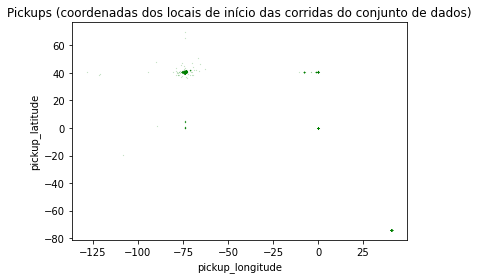

In [ ]:
df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Pickups (coordenadas dos locais de início das corridas do conjunto de dados)");

Conforme podemos notar no gráfico acima, parece que algumas corridas ainda são outliers, visto que estão muito distantes das demais, um indício de que essas viagens não tiveram origem na cidade de New York. Vamos remover os casos de pontos que não estão no intervalo abaixo:

In [ ]:
long_interval = (-74.04, -73.75)
lat_interval = (40.63, 40.88)

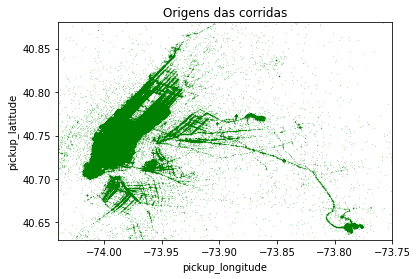

In [ ]:
df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Origens das corridas")
plt.ylim(lat_interval)
plt.xlim(long_interval);

Agora conseguimos visualizar Manhattan :) 

Vamos então filtrar novamente as longitudes e latitudes para considerar somente esses intervalos:

In [ ]:
print(f'Tamanho conjunto de dados (antes da remoção de valores faltantes): {len(df)}')
df = df.loc[(df.pickup_latitude>=40.63) & (df.pickup_latitude<=40.88)]
df = df.loc[(df.pickup_longitude>=-74.04) & (df.pickup_longitude<=-73.75)]
df = df.loc[(df.dropoff_latitude>=40.63) & (df.dropoff_latitude<=40.88)]
df = df.loc[(df.dropoff_longitude>=-74.04) & (df.dropoff_longitude<=-73.75)]
print(f'Tamanho conjunto de dados (depois da remoção de valores faltantes): {len(df)}')

Tamanho conjunto de dados (antes da remoção de valores faltantes): 999479
Tamanho conjunto de dados (depois da remoção de valores faltantes): 970979


**Pontos de destino da corrida**

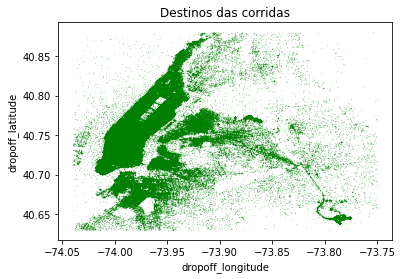

In [ ]:
df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Destinos das corridas");

Comparando com o "mapa" das origens, conseguimos ver que há mais destinos fora de Manhattan, o que indica que muitas corridas começam em Manhattan e terminar no Brooklyn e no Queens.

Além dessa limpeza de outliers, também podemos criar novas variáveis, como as de diferenças absolutas entre as latitudes e as longitudes de origem e destino das corridas:

In [ ]:
df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [ ]:
df[['abs_diff_latitude', 'abs_diff_longitude']].describe()

,abs_diff_latitude,abs_diff_longitude
count,970979.000000,970979.000000
mean,0.020785,0.022129
std,0.021742,0.032358
min,0.000000,0.000000
25%,0.006921,0.006116
50%,0.014084,0.012630
75%,0.026880,0.023665
max,0.237560,0.260020


**`passenger_count`**

Conforme vimos, há casos de corridas com 208 passageiros e também há corridas sem passageiros. 
Vamos supor que todos os carros de táxi só cabem 5 pessoas e, como já há o motorista, o número de passageiros deve ser no máximo 4. Assim, vamos excluir do nosso conjunto de dados os casos de corridas sem passageiros ou com mais de 4:

In [ ]:
len(df.loc[df.passenger_count<1])

3466

In [ ]:
len(df.loc[df.passenger_count>4])

89097

In [ ]:
df = df.loc[(df.passenger_count > 0) & (df.passenger_count<5)]

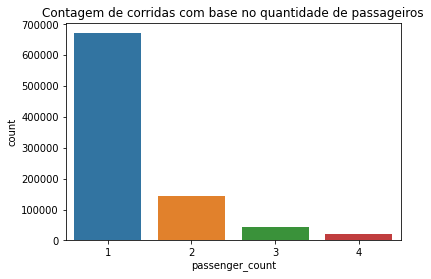

In [ ]:
sns.countplot(df['passenger_count']).set_title("Contagem de corridas com base no quantidade de passageiros");

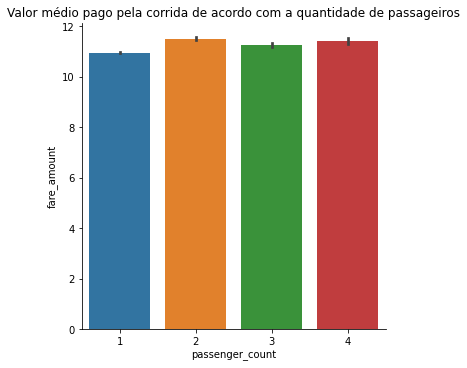

In [ ]:
sns.catplot(x="passenger_count", y="fare_amount", data=df,kind="bar").set(title="Valor médio pago pela corrida de acordo com a quantidade de passageiros");

São pouquíssimas as corridas com 4 passageiros; a maioria absoluta das corridas possuía apenas um passageiro.
Com relação ao valor pago, essas corridas com somente um passageiro parecem ter uma média ligeiramente menor do que as corridas com mais passageiros.

### Correlação

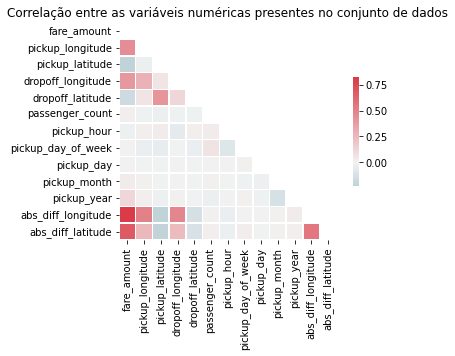

In [ ]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlação entre as variáveis numéricas presentes no conjunto de dados");

De acordo com a matriz de correlação acima, as features que criados referentes às coordenadas de latitude e longitude são as mais correlacionadas com o nosso target.

#### Pronto, vamos parar por aqui com a análise exploratória e feature engineering hoje!

O que mais poderíamos ter feito?

- Ver os dias de feriados nos Estados Unidos
- Tempo no horário do ínicio da corrida (se estava chovendo, muito frio, etc.)
- Calcular a distância entre os pontos de origem e destino da corrida
- Proximidade com estação de metrô

### Regressão Linear Simples

Vamos criar a nossa primeira regressão linear escolhendo a variável que achamos que será a mais relevante. Para criar esse modelo, podemos usar a implementação da regressão linear existente no [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html):

In [ ]:
from sklearn.linear_model import LinearRegression

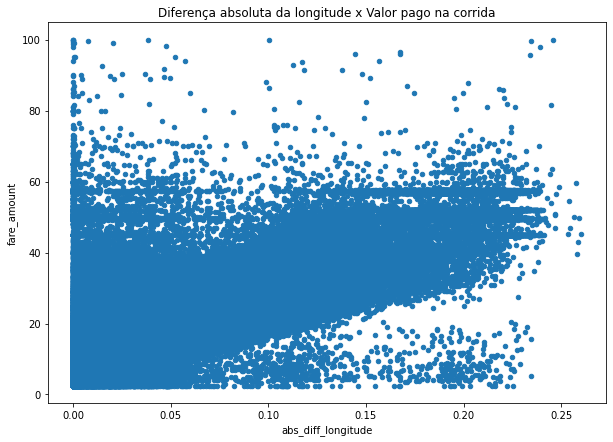

In [ ]:
# Variável target x variável com a diferença absoluta entre as longitudes de origem e destino
_ = df.plot.scatter(x='abs_diff_longitude', y='fare_amount', figsize=(10, 7))
_ = plt.title('Diferença absoluta da longitude x Valor pago na corrida')

In [ ]:
df.fare_amount.corr(df.abs_diff_longitude)

0.8250564877600102

Aparentemente, essa feature é uma boa indicadora para o preço da corrida, visto que a correlação é alta e parece haver uma tendência de que, quanto maior a a diferença da longitude, maior é o preço.

#### Separação do conjunto de treino e teste

In [ ]:
Y = df['fare_amount']
del df['fare_amount']
X = df

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

In [ ]:
print(X_train.shape)
X_train.head(1)

(614891, 15)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day_of_week,pickup_day,pickup_month,pickup_year,pickup_day_of_week_name,abs_diff_longitude,abs_diff_latitude
401364,2015-04-01 09:35:10.0000001,2015-04-01 09:35:10,-73.90744,40.753376,-73.930832,40.744534,1,9,2,1,4,2015,Quarta,0.023392,0.008842


In [ ]:
print(Y_train.shape)
Y_train.head(1)

(614891,)


401364    8.0
Name: fare_amount, dtype: float64

In [ ]:
print(X_test.shape)
X_test.head(1)

(263525, 15)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day_of_week,pickup_day,pickup_month,pickup_year,pickup_day_of_week_name,abs_diff_longitude,abs_diff_latitude
823733,2011-02-26 20:26:00.000000110,2011-02-26 20:26:00,-73.862735,40.76883,-73.969447,40.797897,1,20,5,26,2,2011,Sábado,0.106712,0.029067


In [ ]:
print(Y_test.shape)
Y_test.head(1)

(263525,)


823733    28.1
Name: fare_amount, dtype: float64

#### Treinamento do modelo

In [ ]:
# instancia a regressão linear
lm = LinearRegression()
# como vamos utilizar somente uma feature, vamos passar somente ela para treinar o modelo
lm.fit(X_train[['abs_diff_longitude']], Y_train)

LinearRegression()

#### Predição

In [ ]:
# para fazer a predição também só devemos utilizar a feature fornecida no treinamento
Y_pred = lm.predict(X_test[['abs_diff_longitude']])

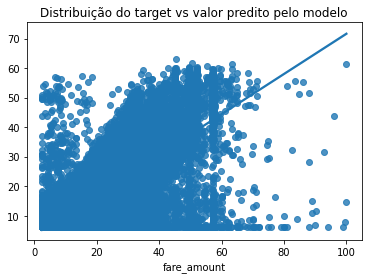

In [ ]:
_ = sns.regplot(x=Y_test, y=Y_pred).set_title("Distribuição do target vs valor predito pelo modelo");

Yay, fizemos nossa primeira regressão linear! O legal é que podemos substituir os valores naquela fórmula do início do notebook para entender algumas coisas:

In [ ]:
# vamos pegar de exemplo o caso em que a diferença das longitudes é de 0.1067120000000017
example = X_test[['abs_diff_longitude']].iloc[0][0]
example

0.1067120000000017

In [ ]:
# aqui conseguimos pegar os coeficientes que compõem a equação da regressão linear
beta=lm.coef_
intercept=lm.intercept_
print(beta)
print(intercept)

[225.37880345]
6.081784576615072


In [ ]:
# Y = (225.37880345 * example) + 6.081784576615056
(beta[0] * example) + intercept

30.13240745082181

Substituindo os valores na fórmula, temos que esse passageiro teria pago cerca de 30 dólares na corrida. E esse valor da fórmula foi exatamente a mesma coisa que nosso modelo predisse:

In [ ]:
Y_pred[0]

30.13240745082181

Há mais duas informações interessantes que podemos observar com os coeficientes:
- Cada vez que a diferença da longitude aumenta em 1, o preço da corrida aumenta em 225 dólares (calma que a diferença das longitudes não é tão alta assim!). 
- Além disso, podemos notar que se a origem e o destino do passageiro fossem o mesmo, ele pagaria 6 dólares.

Conforme tinhamos visto mais acima no notebook, a média da diferença da longitude é de 0.022119. Podemos usar esse número na fórmula que vimos no início da aula para calcular os valores que seriam preditos para a média das viagens:

In [ ]:
(beta * 0.022119) + intercept

array([11.06693833])

Para a média das viagens então, o nosso modelo iria predizer que o valor da corrida seria de quase 11 dólares.

**Mas será que nosso modelo está certo nessas predições?**

![](https://media.giphy.com/media/26xBI73gWquCBBCDe/giphy.gif)

## Métricas de avaliação

Existem diversas métricas para avaliar o erro da predição do nosso modelo. Hoje iremos ver as seguintes:
- MSE (Mean Squared Error)
- MAE (Mean Absolute Error)
- R²

[Aqui](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4) tem um artigo falando sobre outras métricas de avaliação.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**`MSE`**

$\frac{1}{N}\sum{(y_{test} - y_{pred})^2}$

O MSE calcula o erro quadrático médio das predições do nosso modelo. Quanto maior o MSE, pior é o modelo.

Essa métrica é útil quando temos valores de target mais incomuns e que seriam interessantes que nosso modelo não errasse. 

Por outro lado, como os erros são penalizados exponencialmente, erros maiores tem um peso maior do que os erros menores. Então, se o nosso modelo faz apenas uma predição muito, muito ruim, o MSE irá elevar esse erro ao quadrado e, com isso, esse erro ficará ainda pior e acabaremos achando que o nosso modelo está performando pior do que realmente está.

Outro ponto é que a escala do MSE não é a mesma do nosso target (visto que os erros são elevados ao quadrado), então sua interpretação fica mais difícil.

In [ ]:
mse = mean_squared_error(Y_test, Y_pred)
mse

24.697109703696587

**`MAE`**

$\frac{1}{N}\sum{|y_{test} - y_{pred}|}$

O MAE calcula a média da diferença absoluta entre o valor predito e o valor real. Nesse caso, os erros são penalizados linearmente, ou seja, todos terão o mesmo peso na média.

Sua vantagem perante o MSE é que, como a escala é a mesma do target, é mais fácil interpretá-lo. Além disso, essa métrica não penaliza tanto erros maiores como o MSE e, com isso, o MAE não é tão sensível a outliers como o MSE.

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred)
mae

3.1877263310509876

**`R²`**

$1 - \frac{\frac{1}{N}\sum{(y_{test} - y_{pred})^2}}{\frac{1}{N}\sum{(y_{test} - \bar{y})^2}}$

O R² é uma métrica que varia entre -∞ e 1 e é uma razão que indica o quão bom o nosso modelo está em comparação com um modelo naive que faz a predição com base no valor médio do target. Quanto maior seu valor, melhor é nosso modelo com relação a esse modelo mais simplista.

Um valor de R² negativo significa que nosso modelo é pior do que se tivéssemos feito a predição com o valor da média. Entretanto, só com essa métrica não conseguimos enxergar a magnitude dos erros do nosso modelo.

In [ ]:
r2_score(Y_test, Y_pred)

0.6810560930980911

Como no nosso caso temos aqueles valores de corrida por volta de 100 dólares que parecem outliers, vamos considerar somente o MAE e o R<sup>2</sup> para o cálculo dos erros do nosso modelo.

Observando essas métricas de erro, podemos dizer que o modelo não está tão ruim, visto que está melhor do que um modelo que chutasse todos os valores como a média e cujo erro médio absoluto é de cerca de 3 dólares.

Hum, mas será que se nós tivéssemos usado a mediana dos valores pagos na corrida teria sido melhor do que criar um modelo de regressão linear? Será que perdemos nosso tempo? :(

In [ ]:
median = Y_train.median()
median 

8.5

In [ ]:
X_test['median_fare_amount'] = median

In [ ]:
mae = mean_absolute_error(Y_test, X_test['median_fare_amount'])
mae

5.11990744711128

In [ ]:
r2_score(Y_test, X_test['median_fare_amount'])

-0.08501430324232406

Ufa, então nosso modelo está melhor do que essa "predição" pela mediana! \o/

Mas será que escolhemos a melhor feature? Vamos tentar criar outro modelo com outra feature que a gente acredite que seja relevante, calculamos seu erro e verificamos se ele está melhor do que o nosso modelo anterior:

In [ ]:
lm.fit(X_train[['abs_diff_latitude']], Y_train)

LinearRegression()

In [ ]:
Y_pred = lm.predict(X_test[['abs_diff_latitude']])

In [ ]:
beta=lm.coef_
intercept=lm.intercept_
print(beta)
print(intercept)

[279.82492887]
5.25118382146758


In [ ]:
mae = mean_absolute_error(Y_test, Y_pred)
mae

3.718685333704191

In [ ]:
r2_score(Y_test, Y_pred)

0.477625221051739

Olhando o MAE e o R², esse segundo modelo não foi melhor que o primeiro, visto que o MAE aumentou e o R² diminuiu...

Mas vocês acham que faz sentido a gente ficar criando um modelo só com uma feature mesmo ou o ideal seria combinar com outras que temos disponíveis?

## Regressão Linear Múltipla

Sim, nós podemos utilizar mais de uma feature para fazer a nossa regressão! Quando fazemos isso, é uma **regressão linear múltipla**.

<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/38_blog_image_1.png" width="400"/>

Vamos então colocar todas as features que temos disponíveis (e que achamos que fazem sentido):

In [ ]:
columns = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day_of_week', 'pickup_day',
       'pickup_month', 'pickup_year','abs_diff_longitude', 'abs_diff_latitude']

In [ ]:
lm.fit(X_train[columns], Y_train)

LinearRegression()

In [ ]:
Y_pred = lm.predict(X_test[columns])

In [ ]:
beta=lm.coef_
intercept=lm.intercept_

In [ ]:
beta.tolist()

[14.963782473276721,
 2.737995707200696,
 7.607031022297448,
 -18.425442438177704,
 0.11678265334679905,
 0.011291087632848473,
 -0.03347907210247669,
 0.001126808852028649,
 0.0669584128300924,
 0.49129557017506453,
 160.9297290108895,
 137.05547818525534]

In [ ]:
intercept

1324.6273746789398

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred)
mae

2.349518969694522

In [ ]:
r2_score(Y_test, Y_pred)

0.7791099540760904

Parece que temos um modelo melhor! Diminuímos o MAE e aumentamos o R²!

![](http://giphygifs.s3.amazonaws.com/media/AOrThUuuOoDCg/giphy.gif)

Como temos vários coeficientes agora, podemos tentar visualizá-los de uma forma um pouco melhor para entender seus pesos:

In [ ]:
weights = pd.DataFrame(list(zip(columns, lm.coef_.tolist())),columns=['names', 'coefs'])
weights

,names,coefs
0,pickup_longitude,14.963782
1,pickup_latitude,2.737996
2,dropoff_longitude,7.607031
3,dropoff_latitude,-18.425442
4,passenger_count,0.116783
5,pickup_hour,0.011291
6,pickup_day_of_week,-0.033479
7,pickup_day,0.001127
8,pickup_month,0.066958
9,pickup_year,0.491296


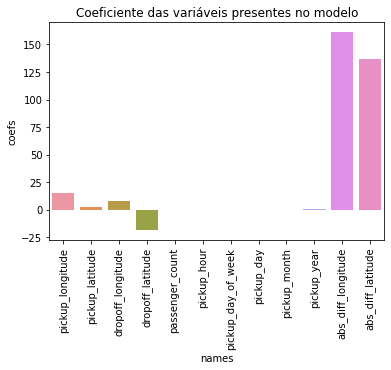

In [ ]:
sns.barplot(weights.names, weights.coefs).set_title("Coeficiente das variáveis presentes no modelo");
plt.xticks(rotation=90);

Aqui podemos ver que os coeficientes maiores são os relacionados às features com a diferença absoluta entre as latitudes e longitudes.

Mas será que faz sentido deixar essas features correlacionadas e que já estão presentes em outras features que criamos, como a `pickup_longitude`?

Podemos treinar mais um modelo de regressão linear múltipla, mas dessa vez removendo as features correlacionadas:

In [ ]:
lm.fit(X_train[['passenger_count', 'pickup_hour', 'pickup_day_of_week', 'pickup_day',
       'pickup_month', 'pickup_year','abs_diff_longitude', 'abs_diff_latitude']], Y_train)

LinearRegression()

In [ ]:
Y_pred = lm.predict(X_test[['passenger_count', 'pickup_hour', 'pickup_day_of_week', 'pickup_day',
       'pickup_month', 'pickup_year','abs_diff_longitude', 'abs_diff_latitude']])

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred)
mae

2.3660051393119104

In [ ]:
r2_score(Y_test, Y_pred)

0.7738888492753323

É, não conseguimos diminuir nosso erro e fazer um modelo melhor que o anterior. Entretanto, como a diferença de erro entre os dois modelos foi bem pequena e os resultados do R² dos dois foi bem parecida, pode ser interessante escolher essa última versão porque com ela temos um modelo menos complexo e que traz resultados satisfatórios.

### E quais são as vantagens de se fazer um modelo utilizando uma regressão linear?

- Ele é um modelo bem simples
- Fácil de entender
- Ideal para problemas em que sabemos que as variáveis independentes (features) e a dependente (target) possuem uma relação linear

### E quais são as desvantagens?

- Muitos problemas no "mundo real" não possuem uma clara relação linear entre o target e as features
- Pode sofrer com outliers

## Próximos passos

![](http://giphygifs.s3.amazonaws.com/media/L6EoLS78pcBag/giphy.gif)

Para exercitar o que aprenderam hoje, vocês podem participar de algumas competições de regressão que existem no Kaggle:
- [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
- [BigQuery-Geotab Intersection Congestion](https://www.kaggle.com/c/bigquery-geotab-intersection-congestion/overview)

Além disso, vocês podem inclusive fazer as predições para o conjunto chamado de `test` disponível na página da competição do Kaggle [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) com o nosso melhor modelo porque usamos justamente esse conjunto de dados de treinamento dessa competição na aula de hoje :D

Possivelmente o resultado não será muito bom, visto que só treinamos o modelo com uma pequena porção do conjunto de dados original. O conjunto de dados na verdade possui **55 milhões de exemplos**!

![](https://media.giphy.com/media/s3qCaXmFQqJsQ/giphy.gif)

Caso vocês queiram treinar esse modelo de novo, mas com mais exemplos, podem tentar usar o [Google Colab](https://colab.research.google.com/).

Além de treinar o modelo com novos exemplos, também pode ser interessante fazer outros tratamentos e análises mencionados na aula ou usar a criatividade e tentar outras coisas para tentar diminuir o erro do modelo ;)

<img src="https://media.giphy.com/media/osjgQPWRx3cac/giphy.gif" width="350"/>